# Exploratory Data Analytics for Grocery Sales


## Importing libraries



In [1]:
!pip install squarify

In [2]:
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import missingno as msno
import numpy as np
import time
import gc

import IPython.display
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from IPython.core.display import display, HTML, Javascript
from string import Template



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Loading the full dataset (5+ GB)

Loading the data using low memory using scripts.  
Script is bootstrapped based on this [Kaggle notebook](https://www.kaggle.com/heyt0ny/read-data-for-low-memory-usage).


In [3]:
class Data(object):
    def __init__(self, data_folder, test_the_script = False):
        self.DATA_FOLDER = data_folder
        self.test_the_script = test_the_script
        self.read_data()
        print('Train shape: ', self.train.shape)

    def read_data(self):

        self.nrows = None
        if self.test_the_script:
            self.nrows = 1000

        self.train = self.read_train_test_low_memory(train_flag = True)
        self.test = self.read_train_test_low_memory(train_flag = False)
        self.stores = self.read_stores_low_memory()
        self.items = self.read_items_low_memory()
        self.oil = self.read_oil_low_memory()
        self.transactions = self.read_transactions_low_memory()
        self.holidays_events = self.read_holidays_events_low_memory()
        self.weather = self.read_weather_low_memory()
            
    def read_train_test_low_memory(self, train_flag = True):
        filename = 'train'
        if not train_flag: filename = 'test'

        types = {'id': 'int64',
                'item_nbr': 'int32',
                'store_nbr': 'int8',
                'unit_sales': 'float32'
            }
        data = pd.read_csv(self.DATA_FOLDER + filename + '.csv', parse_dates = ['date'], dtype = types, 
                        nrows = self.nrows, infer_datetime_format = True, low_memory = True)
        
        # Missing value imputation for onpromotion column
        # Assumption: Missing value == No promotions.
        data['onpromotion'].fillna(False, inplace = True)
        data['onpromotion'] = data['onpromotion'].map({False : 0, True : 1})
        data['onpromotion'] = data['onpromotion'].astype('int8')
        
        return data

    def read_stores_low_memory(self):
        types = {'cluster': 'int32',
                'store_nbr': 'int8',
                }
        data = pd.read_csv(self.DATA_FOLDER + 'stores.csv', dtype = types, low_memory = True)
        return data

    def read_items_low_memory(self):
        types = {'item_nbr': 'int32',
                'perishable': 'int8',
                'class' : 'int16'
                }
        data = pd.read_csv(self.DATA_FOLDER + 'items.csv', dtype = types, low_memory = True)
        return data

    def read_oil_low_memory(self):
        types = {'dcoilwtico': 'float32',
                }
        data = pd.read_csv(self.DATA_FOLDER + 'oil.csv', parse_dates = ['date'], dtype = types, 
                                infer_datetime_format = True, low_memory = True)
        return data

    def read_weather_low_memory(self):
        types = {'MaxTemp': 'int8',
                 'AvgTemp': 'int8'
                }
        data = pd.read_csv(self.DATA_FOLDER + 'weather.csv', parse_dates = ['Date'], dtype = types, 
                                infer_datetime_format = True, low_memory = True)
        return data
    
    def read_transactions_low_memory(self):
        types = {'transactions': 'int16',
                'store_nbr' : 'int8'
                }
        data = pd.read_csv(self.DATA_FOLDER + 'transactions.csv', parse_dates = ['date'], dtype = types, 
                                infer_datetime_format = True, low_memory = True)
        return data

    def read_holidays_events_low_memory(self):
        types = {'transferred': 'boolean',
                }
        data = pd.read_csv(self.DATA_FOLDER + 'holidays_events.csv', parse_dates = ['date'], dtype = types, 
                                infer_datetime_format = True, low_memory = True)
        
        data['transferred'] = data['transferred'].map({False : 0, True : 1})
        data['transferred'] = data['transferred'].astype('int8')

        return data

In [4]:
start_time = time.time()
data = Data(data_folder = 'drive/My Drive/Colab Notebooks/Wishmart/data/', test_the_script = False)
end_time = time.time()
print("Total time elapsed: {} mins.".format((end_time - start_time)/60))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DtypeWarning:

Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.



Train shape:  (125497040, 6)
Total time elapsed: 2.292937362194061 mins.


## Null, missing and duplicate values/ranges check

In [5]:
def check_missing_duplicate(dataset):

  print('Null/Missing values\n', dataset.isnull().sum())

  # making a bool series of duplicated items
  bool_series = dataset.duplicated(keep = False)
  print('Duplicated rows:', dataset[bool_series].shape[0])

  return None

#### Train dataset

In [6]:
data.train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int8          
 3   item_nbr     int32         
 4   unit_sales   float32       
 5   onpromotion  int8          
dtypes: datetime64[ns](1), float32(1), int32(1), int64(1), int8(2)
memory usage: 3.0 GB


In [7]:
# Check for missing values and duplicates
check_missing_duplicate(data.train[['date', 'store_nbr', 'item_nbr']])

Null/Missing values
 date         0
store_nbr    0
item_nbr     0
dtype: int64
Duplicated rows: 0


No missing values or duplicated rows.

Check if all concecutive days are available in the dataset.


In [8]:
df_train_dates_gb = data.train.groupby(['date'])['unit_sales'].sum().reset_index()
date_range = pd.date_range(start=data.train.date.min(), end=data.train.date.max())
missing_dates = set(date_range) - set(df_train_dates_gb['date'])
print('Missing Dates are', missing_dates)

Missing Dates are {Timestamp('2015-12-25 00:00:00', freq='D'), Timestamp('2014-12-25 00:00:00', freq='D'), Timestamp('2013-12-25 00:00:00', freq='D'), Timestamp('2016-12-25 00:00:00', freq='D')}


It can be seen that 25th of December unit-sales are not available in the train dataset.  
**Recommandation: Might not need to impute, but when taking the rolling stats be careful. Rolling mean is preferred. If taking rolling sum, consider the missing day!**

#### Stores data

In [9]:
data.stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int8  
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int32 
dtypes: int32(1), int8(1), object(3)
memory usage: 1.7+ KB


In [10]:
# Check for missing values and duplicates
check_missing_duplicate(data.stores)

Null/Missing values
 store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
Duplicated rows: 0


In [11]:
# Check if any store number is duplicated
data.stores.shape[0] == data.stores['store_nbr'].unique().shape[0]

True

No missing values or duplicates

#### Transactions data

In [12]:
data.transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int8          
 2   transactions  83488 non-null  int16         
dtypes: datetime64[ns](1), int16(1), int8(1)
memory usage: 897.0 KB


In [13]:
# Check for missing values and duplicates
check_missing_duplicate(data.transactions)

Null/Missing values
 date            0
store_nbr       0
transactions    0
dtype: int64
Duplicated rows: 0


#### Items data

In [14]:
data.items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100 entries, 0 to 4099
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   item_nbr    4100 non-null   int32 
 1   family      4100 non-null   object
 2   class       4100 non-null   int16 
 3   perishable  4100 non-null   int8  
dtypes: int16(1), int32(1), int8(1), object(1)
memory usage: 60.2+ KB


In [15]:
check_missing_duplicate(data.items)

Null/Missing values
 item_nbr      0
family        0
class         0
perishable    0
dtype: int64
Duplicated rows: 0


#### Oil data

In [16]:
data.oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 14.4 KB


In [17]:
# Check for missing values and duplicates
check_missing_duplicate(data.oil)

Null/Missing values
 date           0
dcoilwtico    43
dtype: int64
Duplicated rows: 0


No duplicates by have 43 missing values.   
**Recommendation: Forward fill missing values.**

In [11]:
# applying ffill() method to fill the missing values 
data.oil['dcoilwtico_imputed'] = data.oil['dcoilwtico'].ffill(axis = 0) 

Check the timeline for oil data

In [19]:
# Check if data is duplicated
len(data.oil.date.unique()) != len(data.oil.date)

False

In [12]:
train_data_date_range = pd.date_range(start=data.train.date.min(), end=data.train.date.max())
oil_data_date_range = pd.date_range(start=data.oil.date.min(), end=data.oil.date.max())
print('Train data date range', train_data_date_range)
print('Oil data date range', oil_data_date_range)

Train data date range DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', length=1688, freq='D')
Oil data date range DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
               '2017-08-26', '2017-08-27', '2017-08-28', '2017-08-29',
               '2017-08-30', '2017-08-31'],
              dtype='datetime64[ns]', length=1704, freq='D')


Data ranges overlap.

In [21]:
# Check missing dates
missing_dates = set(oil_data_date_range) - set(data.oil.date)
print('Missing Dates are', missing_dates)
print('Missing dates count:', len(missing_dates))

Missing Dates are {Timestamp('2016-10-09 00:00:00', freq='D'), Timestamp('2016-08-28 00:00:00', freq='D'), Timestamp('2014-08-24 00:00:00', freq='D'), Timestamp('2013-02-24 00:00:00', freq='D'), Timestamp('2013-09-15 00:00:00', freq='D'), Timestamp('2014-07-27 00:00:00', freq='D'), Timestamp('2017-08-19 00:00:00', freq='D'), Timestamp('2015-03-08 00:00:00', freq='D'), Timestamp('2016-03-12 00:00:00', freq='D'), Timestamp('2017-05-27 00:00:00', freq='D'), Timestamp('2016-05-01 00:00:00', freq='D'), Timestamp('2013-06-02 00:00:00', freq='D'), Timestamp('2014-06-28 00:00:00', freq='D'), Timestamp('2015-09-26 00:00:00', freq='D'), Timestamp('2017-05-21 00:00:00', freq='D'), Timestamp('2013-04-21 00:00:00', freq='D'), Timestamp('2014-05-03 00:00:00', freq='D'), Timestamp('2017-06-24 00:00:00', freq='D'), Timestamp('2014-11-16 00:00:00', freq='D'), Timestamp('2016-08-20 00:00:00', freq='D'), Timestamp('2013-10-06 00:00:00', freq='D'), Timestamp('2014-01-25 00:00:00', freq='D'), Timestamp('20

486 days are missing from the oil data list.  
Thereby, fill the missing dates.

In [13]:
data.oil = data.oil.reset_index(drop=True).set_index('date')
data.oil.index = pd.DatetimeIndex(data.oil.index)
data.oil = data.oil.reindex(oil_data_date_range)

Forward fill for missing values.

In [14]:
# applying ffill() method to fill the missing values 
data.oil['dcoilwtico_imputed'] = data.oil['dcoilwtico'].ffill(axis = 0) 

In [15]:
data.oil = data.oil.reset_index(drop=False)
data.oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               1704 non-null   datetime64[ns]
 1   dcoilwtico          1175 non-null   float32       
 2   dcoilwtico_imputed  1703 non-null   float32       
dtypes: datetime64[ns](1), float32(2)
memory usage: 26.8 KB


In [25]:
data.oil.head()

,index,dcoilwtico,dcoilwtico_imputed
0,2013-01-01,NaN,NaN
1,2013-01-02,93.139999,93.139999
2,2013-01-03,92.970001,92.970001
3,2013-01-04,93.120003,93.120003
4,2013-01-05,NaN,93.120003


In [16]:
# Backfill only to fill the first row.
data.oil['dcoilwtico_imputed'] = data.oil['dcoilwtico_imputed'].bfill(axis = 0) 

In [17]:
# Rename index column to date
data.oil.rename(columns={'index':'date'}, inplace=True)

print(data.oil.info())
data.oil.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                1704 non-null   datetime64[ns]
 1   dcoilwtico          1175 non-null   float32       
 2   dcoilwtico_imputed  1704 non-null   float32       
dtypes: datetime64[ns](1), float32(2)
memory usage: 26.8 KB
None


,date,dcoilwtico,dcoilwtico_imputed
0,2013-01-01,NaN,93.139999
1,2013-01-02,93.139999,93.139999
2,2013-01-03,92.970001,92.970001
3,2013-01-04,93.120003,93.120003
4,2013-01-05,NaN,93.120003


In [28]:
# Save cleaned dataset
# data.oil.to_csv('drive/My Drive/Colab Notebooks/Wishmart/data/oil_cleaned.csv', index=None)

#### Weather data

In [29]:
data.weather.head()

,Date,MaxTemp,AvgTemp,location
0,2017-02-01,14,8,latacunga
1,2017-02-02,14,9,latacunga
2,2017-02-03,15,9,latacunga
3,2017-02-04,15,9,latacunga
4,2017-02-05,14,9,latacunga


In [30]:
data.weather.shape

(38720, 4)

In [31]:
# Check for missing values and duplicates
check_missing_duplicate(data.weather)

Null/Missing values
 Date        0
MaxTemp     0
AvgTemp     0
location    0
dtype: int64
Duplicated rows: 2420


Drop duplicated values

In [ ]:
# dropping ALL duplicte values 
data.weather.drop_duplicates(keep = 'first', inplace = True)
check_missing_duplicate(data.weather)

Check data range overlap

In [19]:
train_data_date_range = pd.date_range(start=data.train.date.min(), end=data.train.date.max())
weather_data_date_range = pd.date_range(start=data.weather.Date.min(), end=data.weather.Date.max())
print('Train data date range', train_data_date_range)
print('Weather data date range', weather_data_date_range)

Train data date range DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', length=1688, freq='D')
Weather data date range DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-23', '2017-08-24', '2017-08-25', '2017-08-26',
               '2017-08-27', '2017-08-28', '2017-08-29', '2017-08-30',
               '2017-08-31', '2017-09-01'],
              dtype='datetime64[ns]', length=1705, freq='D')


Data ranges overlap.

In [20]:
# Check missing dates
missing_dates = set(weather_data_date_range) - set(data.weather.Date)
print('Missing Dates are', missing_dates)
print('Missing dates count:', len(missing_dates))

Missing Dates are set()
Missing dates count: 0


No missing dates.

In [35]:
# Save cleaned dataset
# data.weather.to_csv('drive/My Drive/Colab Notebooks/Wishmart/data/weather_cleaned.csv', index=None)

#### Holiday data

In [36]:
data.holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    int8          
dtypes: datetime64[ns](1), int8(1), object(4)
memory usage: 14.1+ KB


In [37]:
# Check if any holiday is duplicated
specific_holidays = data.holidays_events[['date', 'type', 'locale', 'locale_name', 'transferred']]
len(specific_holidays.date) - len(specific_holidays.date.unique())

38

Few duplicated days. Possible strategy to merge with train dataset would be;

* If 'locale_name' is some city, append respective 'locale' and 'transferred' columns from holidays to all the stores with given located in that city on that date in train data joined with stores
* If 'locale_name' is some state, append respective 'locale' and 'transferred' columns from holidays to all the stores with given located in that state on that date in train data joined with stores
* Otherwise, append respective 'locale' and 'transferred' columns from holidays to all the stores on that date.

## Explore each dataset

Merge primary datasets for analysis

In [5]:
# Train data and Stores
df_train_stores = pd.merge(data.train, data.stores, on='store_nbr')
del df_train_stores['id']
print(df_train_stores.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125497040 entries, 0 to 125497039
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int8          
 2   item_nbr     int32         
 3   unit_sales   float32       
 4   onpromotion  int8          
 5   city         object        
 6   state        object        
 7   type         object        
 8   cluster      int32         
dtypes: datetime64[ns](1), float32(1), int32(2), int8(2), object(3)
memory usage: 6.3+ GB
None


In [6]:
# Transactions and Stores
df_transactions_stores = pd.merge(data.transactions, data.stores, on='store_nbr')
print(df_transactions_stores.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83488 entries, 0 to 83487
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int8          
 2   transactions  83488 non-null  int16         
 3   city          83488 non-null  object        
 4   state         83488 non-null  object        
 5   type          83488 non-null  object        
 6   cluster       83488 non-null  int32         
dtypes: datetime64[ns](1), int16(1), int32(1), int8(1), object(3)
memory usage: 3.7+ MB
None


Transactions on selected time period, aggregated by date.

In [40]:
dft = data.train[['date', 'unit_sales']].groupby([pd.Grouper(key='date', freq='W')]).sum().reset_index()
dft = dft[dft.date > datetime(2016, 12, 31)]

(array([736330., 736337., 736344., 736351., 736358., 736365., 736372.,
        736379., 736386., 736393., 736400., 736407., 736414., 736421.,
        736428., 736435., 736442., 736449., 736456., 736463., 736470.,
        736477., 736484., 736491., 736498., 736505., 736512., 736519.,
        736526., 736533., 736540., 736547., 736554., 736561.]),
 <a list of 34 Text major ticklabel objects>)

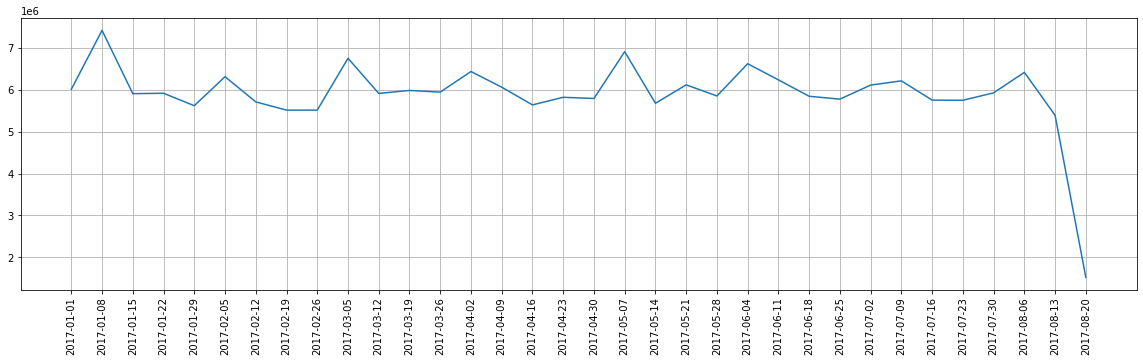

In [41]:
# dft = data.train[['date', 'unit_sales']].groupby([pd.Grouper(key='date', freq='W')]).sum().reset_index()
# dft = dft[dft.date > datetime(2017, 1, 1)]
plt.figure(figsize=(20, 5))
# g = sns.lineplot(x="date", y="unit_sales", data=dft[dft.date > datetime(2017, 1, 1)])
plt.plot(dft.date, dft.unit_sales)
plt.xticks(dft.date)
plt.grid()
plt.xticks(rotation=90)

### Stores data

Delving into store variables - city, staet, type and cluster to understand their relation with number of sales and number of transactions.

In [42]:
city_count_df = data.stores.city.value_counts().to_frame()
state_count_df = data.stores.state.value_counts().to_frame()

Let us have an understanding of store count per city and state.

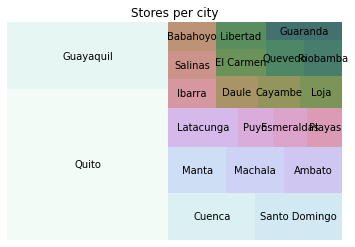

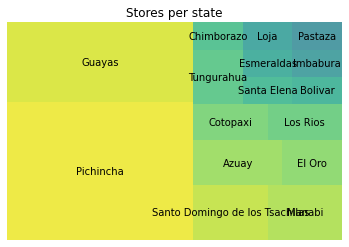

In [43]:
plt.figure()
squarify.plot(sizes=city_count_df.city, label=city_count_df.index, alpha=.8, color=sns.color_palette('cubehelix_r', 28))
plt.title('Stores per city')
plt.axis('off')
plt.show()

plt.figure()
squarify.plot(sizes=state_count_df.state, label=state_count_df.index, alpha=.8, color=sns.color_palette('viridis_r', 28))
plt.title('Stores per state')
plt.axis('off')
plt.show()

Guayas and Pichincha states have the highest number of stores, where as at city level, Quito and Guayaquil proceeds.

#### Unit Sales w.r.t. Type and Cluster

In [44]:
df_s_d = pd.get_dummies(df_train_stores['type'])
for c in df_s_d.columns:
  df_train_stores['Type-'+str(c)] = df_s_d[c]

df_s_c = pd.get_dummies(df_train_stores['cluster'])
for c in df_s_c.columns:
  df_train_stores['Cluster-'+str(c)] = df_s_c[c]

In [45]:
df_train_stores.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster,Type-A,Type-B,Type-C,Type-D,Type-E,Cluster-1,Cluster-2,Cluster-3,Cluster-4,Cluster-5,Cluster-6,Cluster-7,Cluster-8,Cluster-9,Cluster-10,Cluster-11,Cluster-12,Cluster-13,Cluster-14,Cluster-15,Cluster-16,Cluster-17
0,2013-01-01,25,103665,7.0,0,Salinas,Santa Elena,D,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2013-01-01,25,105574,1.0,0,Salinas,Santa Elena,D,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2013-01-01,25,105575,2.0,0,Salinas,Santa Elena,D,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2013-01-01,25,108079,1.0,0,Salinas,Santa Elena,D,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2013-01-01,25,108701,1.0,0,Salinas,Santa Elena,D,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


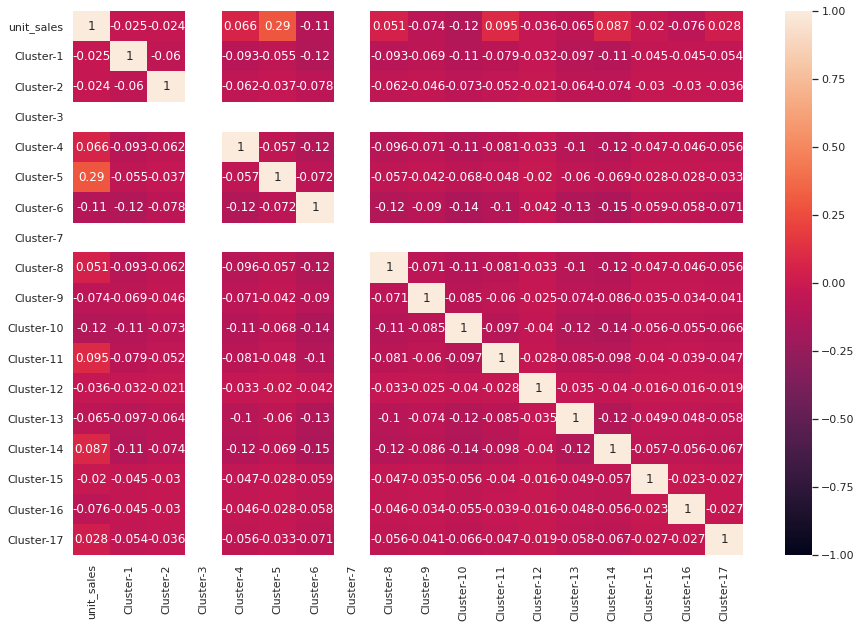

In [46]:
corr_temp = df_train_stores[['item_nbr', 'unit_sales', 'Cluster-1', 'Cluster-2', 'Cluster-3', 'Cluster-4', 'Cluster-5', 'Cluster-6', 'Cluster-7', 'Cluster-8', 'Cluster-9', 'Cluster-10', 'Cluster-11', 'Cluster-12', 'Cluster-13', 'Cluster-14', 'Cluster-15', 'Cluster-16', 'Cluster-17']][(df_train_stores.item_nbr == 103665)][['unit_sales', 'Cluster-1', 'Cluster-2', 'Cluster-3', 'Cluster-4', 'Cluster-5', 'Cluster-6', 'Cluster-7', 'Cluster-8', 'Cluster-9', 'Cluster-10', 'Cluster-11', 'Cluster-12', 'Cluster-13', 'Cluster-14', 'Cluster-15', 'Cluster-16', 'Cluster-17']].corr()
plt.figure(figsize=(15, 10))
sns.set(style="white")
sns.heatmap(corr_temp, annot=True, vmin=-1, vmax=1)

In [47]:
df_train_stores[(df_train_stores.item_nbr == 103665)].corr()

,store_nbr,item_nbr,unit_sales,onpromotion,cluster,Type-A,Type-B,Type-C,Type-D,Type-E,Cluster-1,Cluster-2,Cluster-3,Cluster-4,Cluster-5,Cluster-6,Cluster-7,Cluster-8,Cluster-9,Cluster-10,Cluster-11,Cluster-12,Cluster-13,Cluster-14,Cluster-15,Cluster-16,Cluster-17
store_nbr,1.000000,NaN,0.110956,-0.016999,0.151410,0.688253,-0.111336,-0.134490,-0.497777,0.067411,-0.040160,0.129896,NaN,-0.010799,0.180994,-0.107637,NaN,-0.403845,-0.203943,0.064296,0.305457,-0.068628,-0.335871,0.448933,-0.114999,-0.086234,0.252297
item_nbr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unit_sales,0.110956,NaN,1.000000,-0.006464,-0.025131,0.250535,-0.127785,-0.037619,-0.049143,-0.110208,-0.024791,-0.023531,NaN,0.065586,0.290274,-0.108550,NaN,0.051019,-0.073833,-0.124752,0.094911,-0.036185,-0.064834,0.087461,-0.019991,-0.076329,0.027779
onpromotion,-0.016999,NaN,-0.006464,1.000000,0.005510,-0.070549,0.121883,0.075998,-0.107721,0.092242,-0.037093,-0.014372,NaN,-0.036089,-0.022957,0.107505,NaN,-0.039853,-0.029492,0.084852,-0.032317,0.065839,-0.034789,-0.044281,0.045591,0.026653,-0.023203
cluster,0.151410,NaN,-0.025131,0.005510,1.000000,0.465607,-0.106912,0.215613,-0.436238,0.070992,-0.524097,-0.303362,NaN,-0.334230,-0.157876,-0.247188,NaN,-0.057129,0.008850,0.096396,0.127179,0.076032,0.300949,0.431599,0.208728,0.238347,0.328955
Type-A,0.688253,NaN,0.250535,-0.070549,0.465607,1.000000,-0.275591,-0.108478,-0.536895,-0.157246,-0.173887,-0.115392,NaN,-0.179805,0.318807,-0.227040,NaN,-0.179292,-0.133248,-0.213514,0.452466,-0.062240,-0.187316,0.644926,-0.087821,-0.086301,0.311107
Type-B,-0.111336,NaN,-0.127785,0.121883,-0.106912,-0.275591,1.000000,-0.088972,-0.440357,-0.128972,-0.142621,-0.094644,NaN,-0.147474,-0.087861,0.823828,NaN,-0.147054,-0.109289,0.060809,-0.124696,-0.051049,-0.153635,-0.177736,-0.072030,0.313150,-0.085738
Type-C,-0.134490,NaN,-0.037619,0.075998,0.215613,-0.108478,-0.088972,1.000000,-0.173332,-0.050766,-0.056138,-0.037254,NaN,-0.058048,-0.034583,-0.073298,NaN,-0.057883,-0.043018,-0.068931,-0.049082,0.573762,-0.060474,-0.069960,0.809580,-0.027862,-0.033748
Type-D,-0.497777,NaN,-0.049143,-0.107721,-0.436238,-0.536895,-0.440357,-0.173332,1.000000,-0.251258,0.323875,0.214925,NaN,0.334897,-0.171166,-0.362778,NaN,0.333943,0.248183,-0.209750,-0.242927,-0.099451,0.348888,-0.346257,-0.140326,-0.137898,-0.167032
Type-E,0.067411,NaN,-0.110208,0.092242,0.070992,-0.157246,-0.128972,-0.050766,-0.251258,1.000000,-0.081376,-0.054002,NaN,-0.084146,-0.050131,-0.106251,NaN,-0.083906,-0.062358,0.736468,-0.071149,-0.029127,-0.087661,-0.101412,-0.041099,-0.040388,-0.048920


### Cluster and Type w.r.t. Transactions

There are 17 clusters and 54 stores. We will look through the clusters with respect to; 
* Number of unit sales
* Number of transactions

In [ ]:
# Transactions per month
tpm_df = df_transactions_stores.groupby([df_transactions_stores['date'].dt.strftime('%B'), 'type'])['transactions'].mean().sort_values().to_frame().reset_index()
tpm_df.head()

In [ ]:
sns.barplot(x="type", y="transactions", data=tpm_df)

In [ ]:
#@title Average transactions of
select_month = "September"  #@param ['October', 'November', 'January', 'August', 'July', 'September', 'February', 'March', 'June', 'April', 'May', 'December']

sns.barplot(x="type", y="transactions", data=tpm_df[tpm_df['date'] == select_month])
plt.title('Average transactions on {}'.format(select_month))
plt.show()

For all the months, transaction mean orders as A >> B > D > E > C  
Thereby, we can see that Type A stores has high amount of transactions.

In [ ]:
# Transaction per cluster per month
tpc_df = df_transactions_stores.groupby([df_transactions_stores['date'].dt.strftime('%B'), 'cluster'])['transactions'].mean().sort_values().to_frame().reset_index()
tpc_df.head()

In [ ]:
sns.barplot(x="cluster", y="transactions", data=tpc_df)

In [ ]:
#@title Average transactions of
select_month = "July"  #@param ['October', 'November', 'January', 'August', 'July', 'September', 'February', 'March', 'June', 'April', 'May', 'December']

sns.barplot(x="cluster", y="transactions", data=tpc_df[tpc_df['date'] == select_month])
plt.title('Average Transactions on {}'.format(select_month))
plt.show()

For all the months, cluster 5, has the highest transactions, followed by, 5 > 14 > 22 > 8 > 6

Due to the size of data, further EDA will be carried out through Power BI.

### Items Data

In [ ]:
data.items.head()

In [7]:
items_family_df = data.items.family.value_counts().to_frame().reset_index()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 <a list of 33 Text major ticklabel objects>)

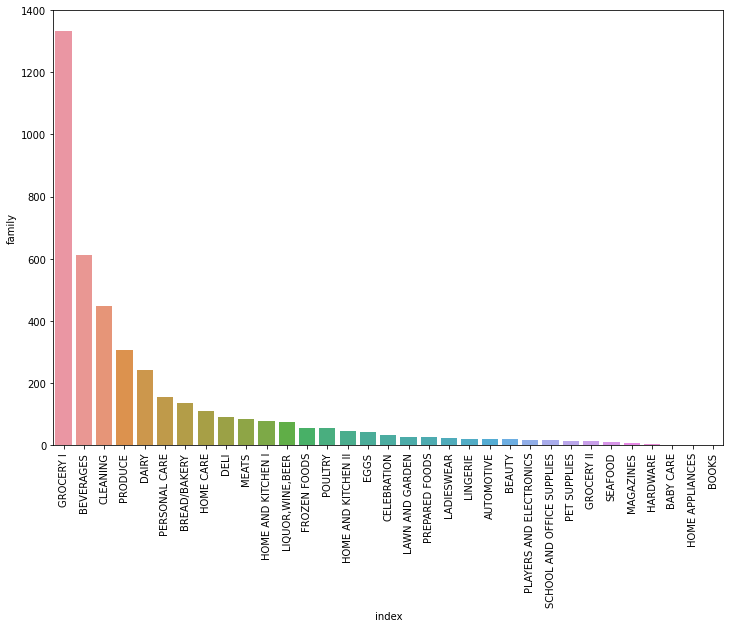

In [8]:
plt.figure(figsize=(12, 8))
fig_family = sns.barplot(x="index", y="family", data=items_family_df)
plt.xticks(rotation=90)

the top 3 family categories are the GROCERY I, BEVERAGES and CLEANING categories

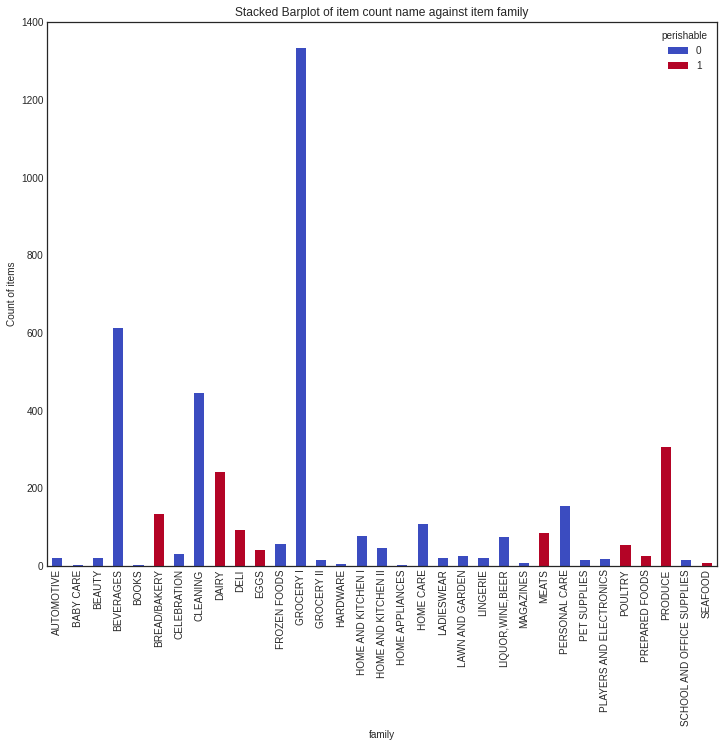

In [9]:
plt.style.use('seaborn-white')
fam_perishable = data.items.groupby(['family', 'perishable']).size()
fam_perishable.unstack().plot(kind='bar', stacked=True, colormap= 'coolwarm', sort_columns =True, figsize=(12,10),  grid=False)
plt.title('Stacked Barplot of item count name against item family')
plt.ylabel('Count of items')
plt.show()

It is important to note that the evaluation matrice proposed that higher weight should be alloted to unit sale prediction of perishable items. This is due to the reason, if persihable items over-predicted (demand << supply), the additional items could decay/rot - which is not the same case with non-perishable items.

### Holidays

In [ ]:
df_store_days = df_train_stores.groupby(['date', 'store_nbr'])[['city', 'state']].agg(pd.Series.mode).reset_index()

In [ ]:
df_store_days.head()

In [ ]:
def holiday_evaluator(row):

  # Check if holiday
  if row['date'] in holiday_days:

    holiday_row_df = data.holidays_events[data.holidays_events['date'] == row[0]]

    for _, hrow in holiday_row_df.iterrows():

      # Check if national
      if hrow['locale'] == 'National':
        return 1

      if hrow['locale'] == 'Regional' and row['state'] == hrow['locale_name'] and hrow['transferred'] == 0:
        return 1
      
      if hrow['locale'] == 'Local' and row['city'] == hrow['locale_name'] and hrow['transferred'] == 0:
        return 1
    

  # If nothings above return false
  return 0

df_store_days['is_holiday'] = df_store_days.apply(holiday_evaluator, axis=1)

In [ ]:
# df_store_days.to_csv('drive/My Drive/Colab Notebooks/Wishmart/data/holiday_refined.csv', index=None)

### Oil and Temperature

In [ ]:
data.oil.head()

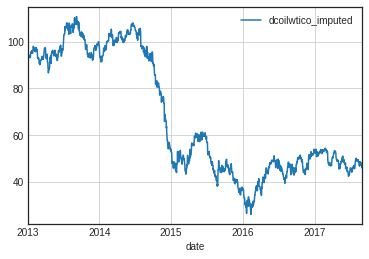

In [21]:
df_oil = data.oil[['date', 'dcoilwtico_imputed']].set_index('date')
df_oil.plot(grid=True)

In [22]:
df_weather = data.weather[['Date', 'MaxTemp', 'AvgTemp', 'location']].set_index('Date')

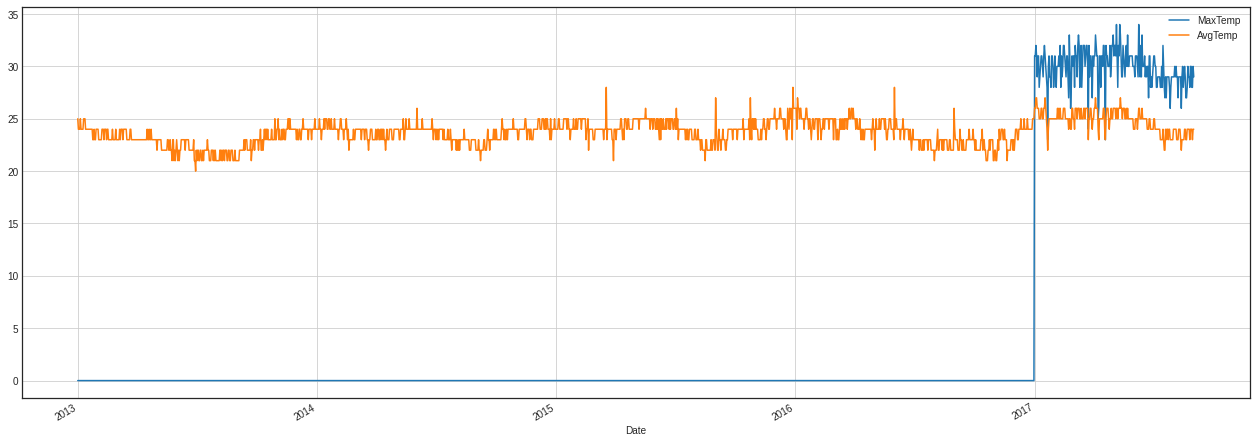

In [23]:
#@title Temperature across cities
city = "el carmen" #@param ['latacunga', 'riobamba', 'ibarra', 'guaranda', 'puyo', 'quito', 'santo domingo', 'cayambe', 'ambato', 'guayaquil', 'playas', 'babahoyo', 'salinas', 'daule', 'quevedo', 'libertad', 'machala', 'esmeraldas', 'manta', 'loja', 'el carmen', 'cuenca']

df_weather[df_weather['location']==city].plot(grid=True, figsize=(22, 8))

Mome missing data on MaxTemp for few cities like EL-Carmon.  
**Recommendation: Use AVGTEMP**

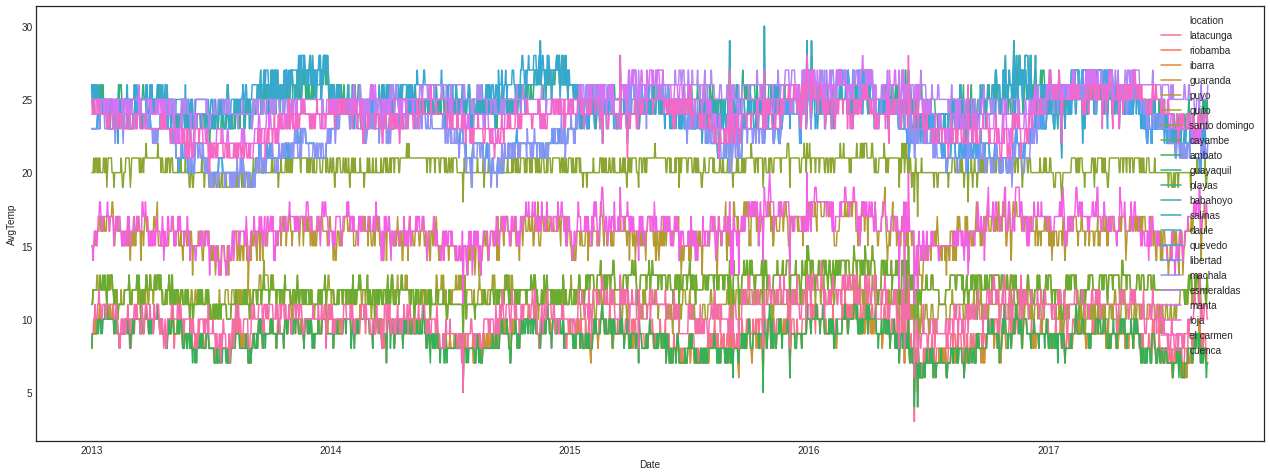

In [24]:
plt.figure(figsize=(22, 8))
sns.lineplot(x="Date", y="AvgTemp", hue="location", data=data.weather[['Date', 'MaxTemp', 'AvgTemp', 'location']])

#### Correlation with sales

In [25]:
# Select unit sales per one store
df_train_store_for_comparision = df_train_stores.groupby(['date', 'store_nbr'])['unit_sales'].sum().reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



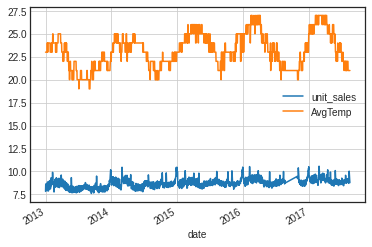

            unit_sales   AvgTemp
unit_sales    1.000000  0.369316
AvgTemp       0.369316  1.000000


In [26]:
store_id = 25

df_store_25 = df_train_store_for_comparision[df_train_store_for_comparision['store_nbr'] == store_id]
df_store_25['location'] = data.stores[data.stores['store_nbr'] == store_id].iloc[0]['city']
df_store_25['location'] = df_store_25['location'].str.lower()

df_weather_25 = pd.merge(df_store_25, data.weather, left_on=['date', 'location'], right_on=['Date', 'location'], how='left')

df_comp = df_weather_25[['date', 'unit_sales', 'AvgTemp']].set_index('date')
df_comp['unit_sales'] = np.log1p(df_comp['unit_sales'])
df_comp.plot(grid=True)
plt.show()

print(df_comp.corr())

In [27]:
# Store and  unit sales
df_sales_store = pd.merge(df_train_store_for_comparision, data.stores[['store_nbr', 'city']], on='store_nbr')
df_sales_store['location'] = df_sales_store.city.str.lower()
df_sales_store_weather = pd.merge(df_sales_store, data.weather[['Date', 'AvgTemp', 'location']], left_on=['date', 'location'], right_on=['Date', 'location'])
del df_sales_store_weather['Date']
del df_sales_store_weather['location']
df_sales_store_weather_oil = pd.merge(df_sales_store_weather, data.oil[['date', 'dcoilwtico_imputed']], on='date')

Correlation between temperature and sales.

In [28]:
from scipy.stats import linregress
from scipy.stats.stats import pearsonr

print(linregress(df_sales_store_weather_oil['unit_sales'], df_sales_store_weather_oil['AvgTemp']))
print('Pearson R:', pearsonr(df_sales_store_weather_oil['unit_sales'], df_sales_store_weather_oil['AvgTemp']))

LinregressResult(slope=-0.00018946359970576726, intercept=18.76414436079385, rvalue=-0.27641713506956445, pvalue=0.0, stderr=2.278178476513686e-06)
Pearson R: (-0.2764171350695647, 0.0)


R = -0.28. I believe this R value to be sufficient to select AvgTemp as a potential feature.

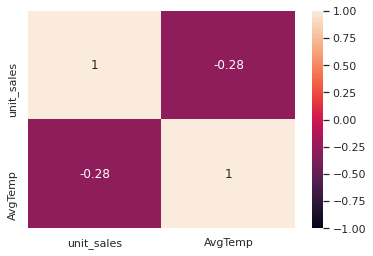

In [29]:
corr_temp = df_sales_store_weather_oil[['unit_sales', 'AvgTemp']].corr()
sns.set(style="white")
sns.heatmap(corr_temp, annot=True, vmin=-1, vmax=1)

In [30]:
from scipy.stats.stats import pearsonr

print(linregress(df_sales_store_weather_oil['unit_sales'], df_sales_store_weather_oil['dcoilwtico_imputed']))
print('Pearson R:', pearsonr(df_sales_store_weather_oil['unit_sales'], df_sales_store_weather_oil['dcoilwtico_imputed']))

LinregressResult(slope=-0.0006306932951874707, intercept=74.71942404100368, rvalue=-0.23984901194433547, pvalue=0.0, stderr=8.828787915876923e-06)
Pearson R: (-0.23984901194433517, 0.0)


R = -0.23. Less correlated that AvgTemp, however, sufficient to select as a potential feature.

In [31]:
df_sales_store_weather_oil.head()

,date,store_nbr,unit_sales,city,AvgTemp,dcoilwtico_imputed
0,2013-01-01,25,2511.618896,Salinas,23,93.139999
1,2013-01-02,25,5316.224121,Salinas,23,93.139999
2,2013-01-02,1,7417.147949,Quito,11,93.139999
3,2013-01-02,2,10266.718750,Quito,11,93.139999
4,2013-01-02,3,24060.347656,Quito,11,93.139999


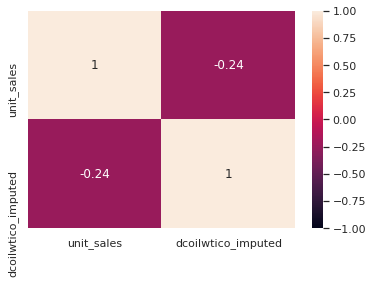

In [32]:
corr_temp = df_sales_store_weather_oil[['unit_sales', 'dcoilwtico_imputed']].corr()
sns.set(style="white")
sns.heatmap(corr_temp, annot=True, vmin=-1, vmax=1)

In [33]:
from scipy.stats.stats import pearsonr

print(linregress(df_sales_store_weather_oil['AvgTemp'], df_sales_store_weather_oil['dcoilwtico_imputed']))
print('Pearson R:', pearsonr(df_sales_store_weather_oil['AvgTemp'], df_sales_store_weather_oil['dcoilwtico_imputed']))

LinregressResult(slope=-0.10117549862449232, intercept=68.27281437845951, rvalue=-0.02637277903541212, pvalue=2.406097316120253e-14, stderr=0.013263399333108224)
Pearson R: (-0.026372779035412117, 2.4060973160910553e-14)


Temperature and Oil price are not correlated with each other, thus, can select both instead of one representation.


#### Save daily_storewise_temperature

In [ ]:
df_store_days['city_lower'] = df_store_days['city'].str.lower()
df_store_weather = pd.merge(df_store_days, data.weather, left_on=['date', 'city_lower'], right_on=['Date', 'location'], how='left')
df_store_weather.drop(columns=['city_lower','Date', 'MaxTemp', 'location'], inplace=True)

df_store_weather_oil = pd.merge(df_store_weather, data.oil, left_on=['date'], right_on=['date'], how='left')
df_store_weather_oil.drop(columns=['dcoilwtico'], inplace=True)

In [34]:
# df_store_weather_oil.to_csv('drive/My Drive/Colab Notebooks/Wishmart/data/holiday_weather_oil_combined.csv', index=None)

### Train data

When the sales are returned it is considered as negative values.  
**Recommendation: Clip unit_sales to zero.**

In [35]:
data.train.head()
del data.train['id']

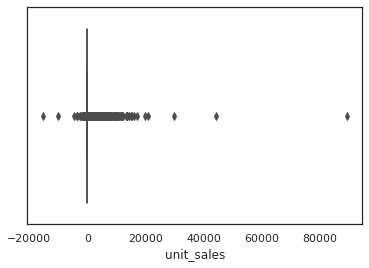

In [36]:
sns.boxplot(x=data.train.unit_sales)

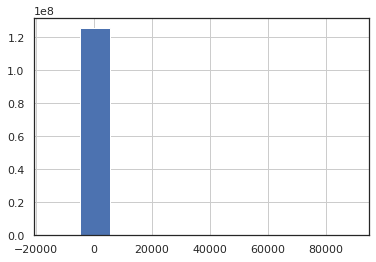

In [37]:
data.train.unit_sales.hist()

We have a wide distribution. We we will remove the common e.g., 0-100 values and revisit the distribution.

In [38]:
# Check the values above 0.95 quantile
data.train.unit_sales.quantile(.995)

100.0

In [39]:
data.train[['unit_sales']].kurtosis(axis = 0, skipna = True) 

unit_sales    1796939.375
dtype: float32

**Recommendation: Clip the higher >.995 percentile (i.e., 100) to 100.**

In [40]:
data.train.unit_sales.clip(0.000001, 100, inplace=True)

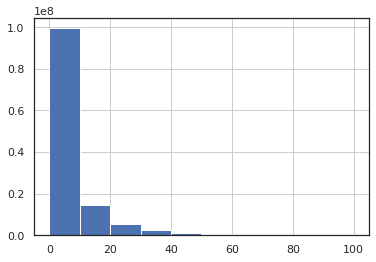

In [41]:
data.train.unit_sales.hist()

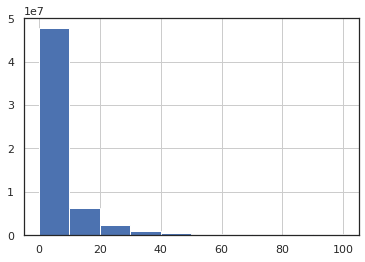

In [42]:
from_date = datetime(2016,1,1)
to_date = datetime(2018,3,1)
df_train_filt = data.train[(from_date <= data.train['date']) & (data.train['date'] < to_date)]  

df_train_filt.unit_sales.hist()

The target variable has a right skewed distribution. Options include log transformation.

#### Trend and Seasonality

In [43]:
df_ts_daily = data.train.groupby(['store_nbr', pd.Grouper(key='date', freq='D')])['unit_sales'].sum().reset_index().sort_values('date')

In [44]:
df_ts_daily['dow'] = df_ts_daily.date.dt.day_name()

In [45]:
df_ts_daily[df_ts_daily.date > datetime(2017,1,1)]

,store_nbr,date,unit_sales,dow
14884,9,2017-01-02,36448.937500,Monday
61227,39,2017-01-02,24368.865234,Monday
31464,19,2017-01-02,14565.575195,Monday
66982,43,2017-01-02,20094.019531,Monday
62906,40,2017-01-02,17999.226562,Monday
...,...,...,...,...
40577,26,2017-08-15,3694.896973,Tuesday
67207,43,2017-08-15,14613.957031,Tuesday
77281,49,2017-08-15,27210.140625,Tuesday
68886,44,2017-08-15,30839.085938,Tuesday


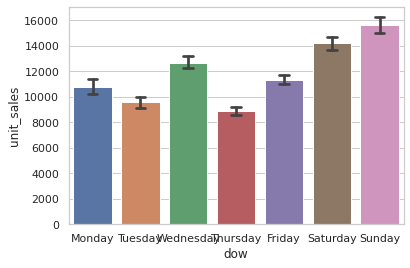

In [46]:
sns.set(style="whitegrid")
sns.barplot(x="dow", y="unit_sales", data=df_ts_daily[(df_ts_daily.date > datetime(2017,1,1)) & (df_ts_daily.store_nbr == 53)], capsize=.2)

Daily Trends

In [47]:
del df_ts_daily
gc.collect()

0

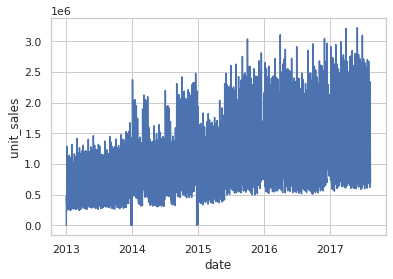

In [48]:
df_ts_daily = data.train.groupby([pd.Grouper(key='date', freq='B')])['unit_sales'].sum().reset_index().sort_values('date')
sns.lineplot(x="date", y="unit_sales", data=df_ts_daily)

In [49]:
df_ts_fn = data.train.groupby([pd.Grouper(key='date', freq='SM')])['unit_sales'].sum().reset_index().sort_values('date')

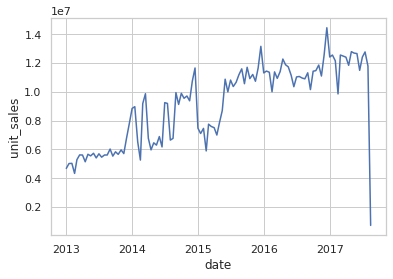

In [50]:
sns.lineplot(x="date", y="unit_sales", data=df_ts_fn)

Weekly Trends

In [51]:
df_ts = data.train.groupby([pd.Grouper(key='date', freq='W-MON')])['unit_sales'].sum().reset_index().sort_values('date')

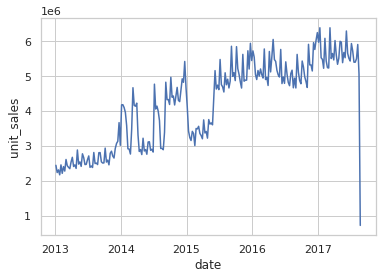

In [52]:
sns.lineplot(x="date", y="unit_sales", data=df_ts)

Monthly Trends

In [53]:
df_ts_monthly = data.train.groupby([pd.Grouper(key='date', freq='M')])['unit_sales'].sum().reset_index().sort_values('date')

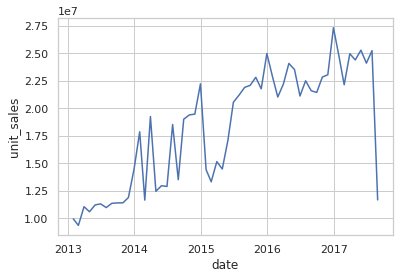

In [54]:
sns.lineplot(x="date", y="unit_sales", data=df_ts_monthly)

Seasonality

In [55]:
from statsmodels.tsa.seasonal import seasonal_decompose

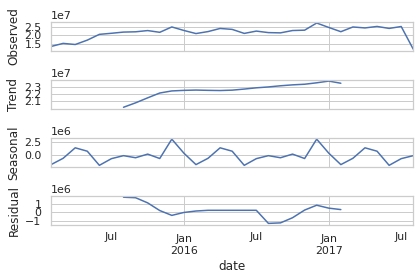

<Figure size 1440x576 with 0 Axes>

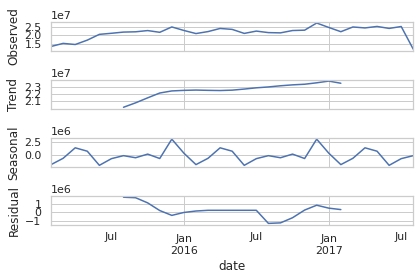

In [56]:
dft = data.train.groupby([pd.Grouper(key='date', freq='MS')])['unit_sales'].sum().reset_index().sort_values('date')
temp = dft[dft.date > datetime(2015,1,1)].set_index('date')
result = seasonal_decompose(temp)
plt.figure(figsize=(20, 8))
result.plot()

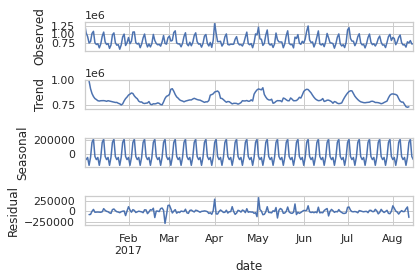

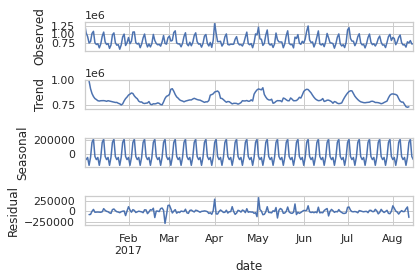

In [57]:
dft = data.train.groupby([pd.Grouper(key='date', freq='D')])['unit_sales'].sum().reset_index().sort_values('date')
temp = dft[dft.date > datetime(2017,1,1)].set_index('date')
result = seasonal_decompose(temp)
result.plot()

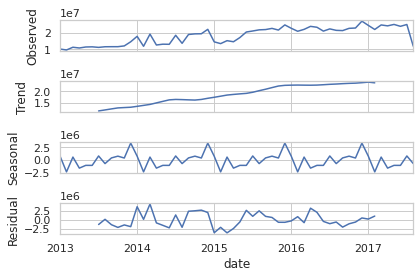

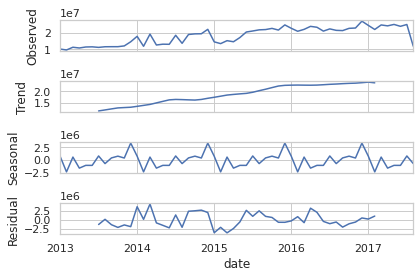

In [58]:
result = seasonal_decompose(df_ts_monthly.set_index('date'))
result.plot()

#### Log Transformation

In [59]:
log_unit_sales = np.log1p(df_train_filt['unit_sales'])

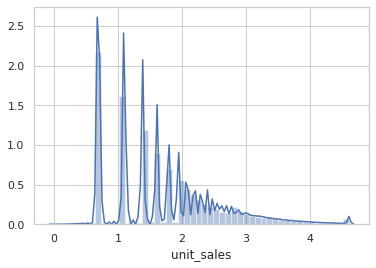

In [60]:
sns.distplot(log_unit_sales)

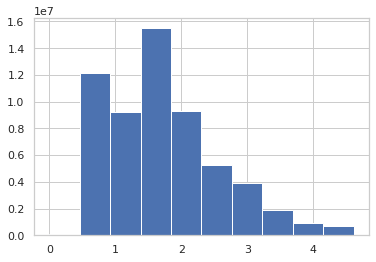

In [61]:
log_unit_sales.hist()

Rescaling the log values

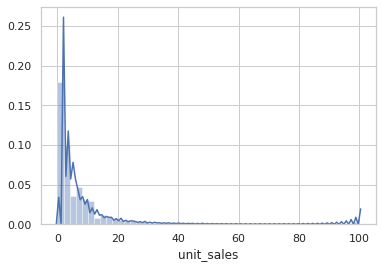

In [62]:
sns.distplot(np.expm1(log_unit_sales))

#### Normalize: Mean SD

In [63]:
df_train_filt.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion
66458908,2016-01-01,25,105574,12.0,0
66458909,2016-01-01,25,105575,9.0,0
66458910,2016-01-01,25,105857,3.0,0
66458911,2016-01-01,25,108634,3.0,0
66458912,2016-01-01,25,108701,2.0,1


In [64]:
mean_item = df_train_filt[['item_nbr','unit_sales']].groupby(['item_nbr'])['unit_sales'].mean().to_frame('mean')
std_item = df_train_filt[['item_nbr','unit_sales']].groupby(['item_nbr'])['unit_sales'].std().to_frame('std')

df_train_filt = df_train_filt.merge(right=mean_item, left_on='item_nbr', right_on='item_nbr')
df_train_filt = df_train_filt.merge(right=std_item, left_on='item_nbr', right_on='item_nbr')
df_train_filt['unit_sales'] = df_train_filt['unit_sales'] - df_train_filt['mean']
df_train_filt['unit_sales'] = df_train_filt['unit_sales'].divide(df_train_filt['std'],fill_value=0)
df_train_filt.drop(columns=['mean','std'],inplace=True)

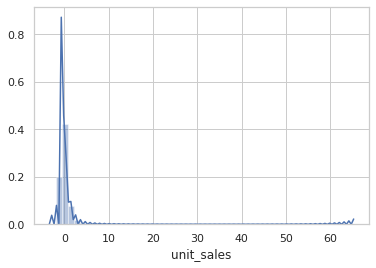

In [65]:
sns.distplot(df_train_filt.unit_sales)

This shows log transformation performs well comparatively to normalization.